In [ ]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


from collections import Counter
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
import joblib

from processing_data import *

##### Data Processing

In [2]:
sepsis_data_intake = initial_intake_process_of_data(data_type='train',load_tables='no')
data_dict, factors = sepsis_data_intake.process_data()

sepsis_data_processing = post_merge_process(data_dict=data_dict,factors=factors,data_type='train')
sepsis_data_processing.post_join_processing_train(10000)

factors_for_modeling = sepsis_data_processing.factors.copy()

Adding UIDs.
UIDs added
Beginning processing for person_demographics_episode_train.
Finished processing of person_demographics_episode_train.
Beginning processing for measurement_meds_train.
Finished processing of measurement_meds_train.
Beginning processing for drugsexposure_train.


100%|██████████| 27594/27594 [41:32<00:00, 11.07it/s]    


Finished processing of drugsexposure_train.
Beginning processing for measurement_lab_train.
Finished processing of measurement_lab_train.
Beginning processing for proceduresoccurrences_train.
Finished processing of proceduresoccurrences_train.
Beginning processing for observation_train.
Finished processing of observation_train.
Beginning processing for measurement_observation_train.
Finished processing of measurement_observation_train.
Beginning processing for devices_train.
Finished processing of devices_train.
Beginning processing for SepsisLabel_train.
Finished processing of SepsisLabel_train.
Beginning adding new_person_id column based on uids.
Finished adding new_person_id column based on uids.
Beginning birthday ubiquity.
Birthday ubiquity established.
Adding visit reason


100%|██████████| 331623/331623 [11:08<00:00, 496.37it/s]


Visit reasons added
Clearing columns.
Columns cleared.
filling NaN values using Gaussians.
filled NaN values using Gaussians.
Filling zero values for one hot encoding columns.
Zeros filled.
Beginning categorical encoding.


100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


Finished categorical encoding.


In [3]:
split_data, column_names = format_for_modeling(factors_for_modeling)

##### Random Forest Model

In [4]:
def forest_model(data_dictionary: dict):
    X_train = data_dictionary['X_train']
    X_test = data_dictionary['X_test']
    y_train = data_dictionary['y_train']
    y_test = data_dictionary['y_test']
    person_id_train = data_dictionary['person_id_train']
    person_id_test = data_dictionary['person_id_test']

    r_forest_model = RandomForestClassifier(class_weight={0:1,1:150})
    r_forest_model.fit(X_train,y_train)

    y_pred = r_forest_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {accuracy}")
    f1 = f1_score(y_test,y_pred)
    print(f"F1 score: {f1}")

    cm = confusion_matrix(y_test, y_pred)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return r_forest_model, y_pred

Accuracy score: 0.9736217725052337
F1 score: 0.2676998943289891


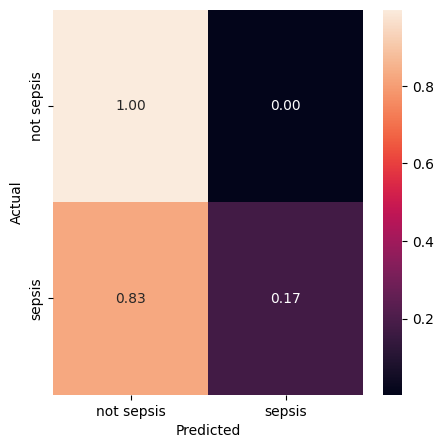

In [5]:
forest, preds = forest_model(split_data)

In [6]:
importance = pd.DataFrame({'factors': column_names, 'importance': forest.feature_importances_}).sort_values(by='importance',ascending=False)
importance

,factors,importance
78,ohe_Intravenous,0.320257
48,ohe_epinephrine,0.137706
63,ohe_milrinone,0.057496
89,age,0.053953
47,ohe_dopamine,0.051526
...,...,...
83,ohe_Rectal,0.000000
79,ohe_Nasal,0.000000
34,ohe_cefadroxil,0.000000
65,ohe_nitrofurantoin,0.000000


##### XGB Classifier

In [7]:
def xgb_model(data_dictionary: dict):
    X_train = data_dictionary['X_train']
    X_test = data_dictionary['X_test']
    y_train = data_dictionary['y_train']
    y_test = data_dictionary['y_test']
    person_id_train = data_dictionary['person_id_train']
    person_id_test = data_dictionary['person_id_test']


    r_xgb_model = XGBClassifier(scale_pos_weight = 150, learning_rate=0.1, n_estimators=300, max_depth=15)
    r_xgb_model.fit(X_train, y_train)

    y_pred = r_xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {accuracy}")
    f1 = f1_score(y_test,y_pred)
    print(f"F1 score: {f1}")

    cm = confusion_matrix(y_test, y_pred)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return r_xgb_model, y_pred

Accuracy score: 0.9789507073526613
F1 score: 0.5859745445470427


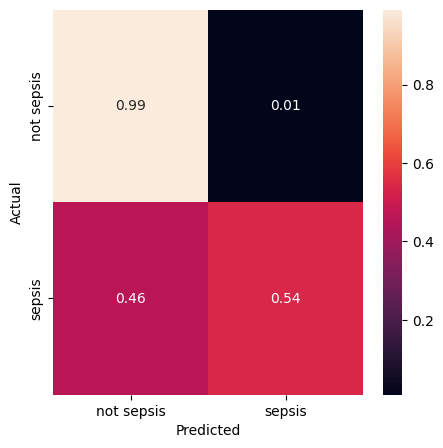

In [8]:
xgb, preds = xgb_model(split_data)

In [9]:
importance = pd.DataFrame({'factors': column_names, 'importance': xgb.feature_importances_}).sort_values(by='importance',ascending=False)
importance

,factors,importance
78,ohe_Intravenous,0.846279
48,ohe_epinephrine,0.018964
74,ohe_trimethoprim,0.013646
47,ohe_dopamine,0.013306
58,ohe_levosimendan,0.010713
...,...,...
67,ohe_penicillin G,0.000000
68,ohe_phenylephrine,0.000000
70,ohe_prednisolone,0.000000
50,ohe_erythromycin,0.000000


##### HGBC Model

In [10]:
def run_hgbc(data_dictionary: dict):
    X_train = data_dictionary['X_train']
    X_test = data_dictionary['X_test']
    y_train = data_dictionary['y_train']
    y_test = data_dictionary['y_test']
    
    # class_weight={0:1,1:150}
    hgbc_classifier = HistGradientBoostingClassifier(class_weight={0:1,1:150})
    hgbc_classifier.fit(X_train, y_train)

    y_pred = hgbc_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {accuracy}")
    f1 = f1_score(y_test,y_pred)
    print(f"F1 score: {f1}")

    cm = confusion_matrix(y_test, y_pred)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return hgbc_classifier, y_pred

Accuracy score: 0.9341242149337056
F1 score: 0.3993521517815826


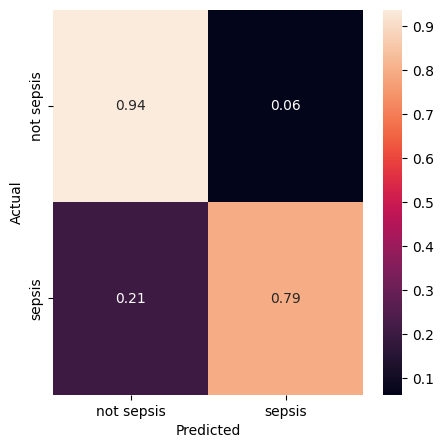

In [11]:
hgbc, preds = run_hgbc(split_data)

In [12]:
importance = pd.DataFrame({'factors': column_names, 'importance': hgbc.feature_importances_}).sort_values(by='importance',ascending=False)
importance

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'